# ntpl005_introspection
Write and read an RNTuple from a user-defined class.  Adapted from tv3.C
Illustrates various RNTuple introspection methods.




**Author:** The ROOT Team  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:24 AM.</small></i>

In [1]:
%%cpp -d

NOTE: The RNTuple classes are experimental at this point.
Functionality, interface, and data format is still subject to changes.
Do not use for real data!

In [2]:
%%cpp -d
#include <ROOT/RNTupleModel.hxx>
#include <ROOT/RNTupleReader.hxx>
#include <ROOT/RNTupleWriteOptions.hxx>
#include <ROOT/RNTupleWriter.hxx>

#include <Compression.h>
#include <TCanvas.h>
#include <TH1.h>
#include <TRandom.h>
#include <TSystem.h>

#include <cassert>

Import classes from experimental namespace for the time being

In [3]:
using ENTupleInfo = ROOT::Experimental::ENTupleInfo;
using RNTupleModel = ROOT::Experimental::RNTupleModel;
using RNTupleReader = ROOT::Experimental::RNTupleReader;
using RNTupleWriter = ROOT::Experimental::RNTupleWriter;
using RNTupleWriteOptions = ROOT::Experimental::RNTupleWriteOptions;

constexpr char const* kNTupleFileName = "ntpl005_introspection.root";

Store entries of type Vector3 in the ntuple

In [4]:
class Vector3 {
private:
   double fX = 0;
   double fY = 0;
   double fZ = 0;

public:
   double x() const { return fX; }
   double y() const { return fY; }
   double z() const { return fZ; }

   void SetXYZ(double x, double y, double z) {
      fX = x;
      fY = y;
      fZ = z;
   }
};

 Definition of a helper function: 

In [5]:
%%cpp -d


void Generate()
{
   auto model = RNTupleModel::Create();
   auto fldVector3 = model->MakeField<Vector3>("v3");

   // Explicitly enforce a certain compression algorithm
   RNTupleWriteOptions options;
   options.SetCompression(ROOT::RCompressionSetting::EDefaults::kUseGeneralPurpose);

   auto ntuple = RNTupleWriter::Recreate(std::move(model), "Vector3", kNTupleFileName, options);
   TRandom r;
   for (unsigned int i = 0; i < 500000; ++i) {
      fldVector3->SetXYZ(r.Gaus(0,1), r.Landau(0,1), r.Gaus(100,10));
      ntuple->Fill();
   }
}

In [6]:
Generate();

auto ntuple = RNTupleReader::Open("Vector3", kNTupleFileName);

Warning in <[ROOT.NTuple] Warning /home/sftnight/build/workspace/root-makedoc-master/rootspi/rdoc/src/master/tree/ntuple/v7/src/RPageStorageFile.cxx:56 in ROOT::Experimental::Internal::RPageSinkFile::RPageSinkFile(std::string_view, const ROOT::Experimental::RNTupleWriteOptions&)::<lambda()>>: The RNTuple file format will change. Do not store real data with this version of RNTuple!
Warning in <[ROOT.NTuple] Warning /home/sftnight/build/workspace/root-makedoc-master/rootspi/rdoc/src/master/tree/ntuple/v7/src/RPageStorageFile.cxx:262 in ROOT::Experimental::Internal::RPageSourceFile::InitDescriptor(const ROOT::Experimental::RNTuple&)::<lambda()>>: Pre-release format version: RC 2


Display the schema of the ntuple

In [7]:
ntuple->PrintInfo();

************************************ NTUPLE ************************************
* N-Tuple : Vector3                                                            *
* Entries : 500000                                                             *
********************************************************************************
* Field 1       : v3 (Vector3)                                                 *
*   Field 1.1   : fX (double)                                                  *
*   Field 1.2   : fY (double)                                                  *
*   Field 1.3   : fZ (double)                                                  *
********************************************************************************


Display information about the storage layout of the data

In [8]:
ntuple->PrintInfo(ENTupleInfo::kStorageDetails);

NTUPLE:      Vector3
Compression: 505
------------------------------------------------------------
  # Entries:        500000
  # Fields:         5
  # Columns:        3
  # Alias Columns:  0
  # Pages:          183
  # Clusters:       1
  Size on storage:  10434666 B
  Compression rate: 1.15
  Header size:      148 B
  Footer size:      1301 B
  Meta-data / data: 0.000
------------------------------------------------------------
CLUSTER DETAILS
------------------------------------------------------------
  #     0   Entry range:     [0..499999]  --  500000
            # Pages:         183
            Size on storage: 10434666 B
            Compression:     1.15
------------------------------------------------------------
COLUMN DETAILS
------------------------------------------------------------
  v3.fX [#0]  --  SplitReal64                         {id:0}
    # Elements:          500000
    # Pages:             61
    Avg elements / page: 8196
    Avg page size:       57583 B
    Size

Display the first entry

In [9]:
ntuple->Show(0);

{
  "v3": {
    "fX": -0.15,
    "fY": 5.48,
    "fZ": 93.87
  }
}


Collect I/O runtime counters when processing the data set.
Maintaining the counters comes with a small performance overhead, so it has to be explicitly enabled

In [10]:
ntuple->EnableMetrics();

Plot the y components of vector3

In [11]:
TCanvas *c1 = new TCanvas("c1","RNTuple Demo", 10, 10, 600, 800);
c1->Divide(1,2);
c1->cd(1);
TH1F h1("x", "x component of Vector3", 100, -3, 3);
{
   /// We enclose viewX in a scope in order to indicate to the RNTuple when we are not
   /// anymore interested in v3.fX
   auto viewX = ntuple->GetView<double>("v3.fX");
   for (auto i : ntuple->GetEntryRange()) {
      h1.Fill(viewX(i));
   }
}
h1.DrawCopy();

c1->cd(2);
TH1F h2("y", "y component of Vector3", 100, -5, 20);
auto viewY = ntuple->GetView<double>("v3.fY");
for (auto i : ntuple->GetEntryRange()) {
   h2.Fill(viewY(i));
}
h2.DrawCopy();

Display the I/O operation statistics performed by the RNTuple reader

In [12]:
ntuple->PrintInfo(ENTupleInfo::kMetrics);

RNTupleReader.RPageSourceFile.nReadV||number of vector read requests|2
RNTupleReader.RPageSourceFile.nRead||number of byte ranges read|2
RNTupleReader.RPageSourceFile.szReadPayload|B|volume read from storage (required)|7173225
RNTupleReader.RPageSourceFile.szReadOverhead|B|volume read from storage (overhead)|0
RNTupleReader.RPageSourceFile.szUnzip|B|volume after unzipping|8000000
RNTupleReader.RPageSourceFile.nClusterLoaded||number of partial clusters preloaded from storage|2
RNTupleReader.RPageSourceFile.nPageLoaded||number of pages loaded from storage|122
RNTupleReader.RPageSourceFile.nPagePopulated||number of populated pages|122
RNTupleReader.RPageSourceFile.timeWallRead|ns|wall clock time spent reading|6034409
RNTupleReader.RPageSourceFile.timeWallUnzip|ns|wall clock time spent decompressing|25394979
RNTupleReader.RPageSourceFile.timeCpuRead|ns|CPU time spent reading|6069000
RNTupleReader.RPageSourceFile.timeCpuUnzip|ns|CPU time spent decompressing|24631000
RNTupleReader.RPageSourc

We read 2 out of the 3 Vector3 members and thus should have requested approximately 2/3 of the file

In [13]:
FileStat_t fileStat;
auto retval = gSystem->GetPathInfo(kNTupleFileName, fileStat);
assert(retval == 0);
float fileSize = static_cast<float>(fileStat.fSize);
float nbytesRead = ntuple->GetMetrics().GetCounter("RNTupleReader.RPageSourceFile.szReadPayload")->GetValueAsInt() +
                   ntuple->GetMetrics().GetCounter("RNTupleReader.RPageSourceFile.szReadOverhead")->GetValueAsInt();

std::cout << "File size:      " << fileSize / 1024. / 1024. << " MiB" << std::endl;
std::cout << "Read from file: " << nbytesRead / 1024. / 1024. << " MiB" << std::endl;
std::cout << "Ratio:          " << nbytesRead / fileSize << std::endl;

File size:      9.95 MiB
Read from file: 6.84 MiB
Ratio:          0.69


Draw all canvases 

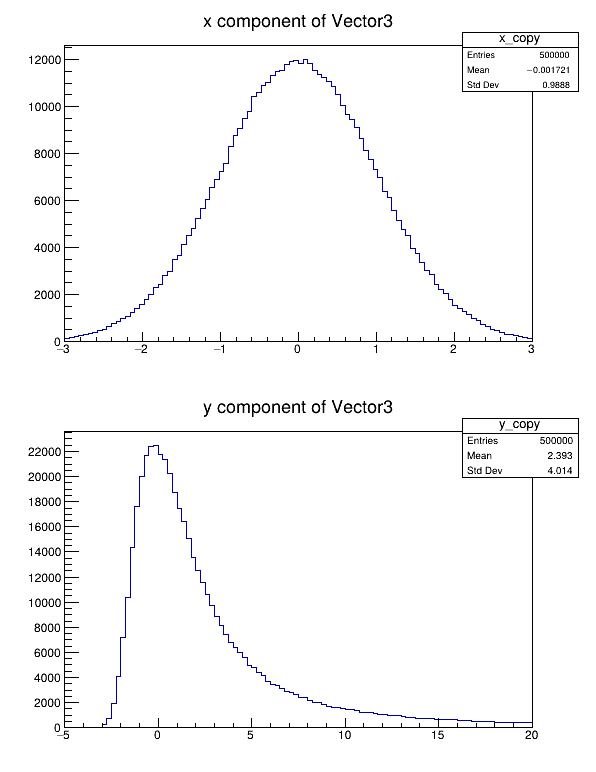

In [14]:
gROOT->GetListOfCanvases()->Draw()